Problem 4
========

In [1]:
import torch
import torch.nn as nn
from torchinfo import summary
from torchviz import make_dot
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np

In [2]:
class STMConvLayer(nn.Module):
    def __init__(self):
        super(STMConvLayer, self).__init__()
        self.layer1 = nn.ModuleList([
            nn.Conv2d(256,4,kernel_size =1, stride = 1)
            for i in range(32)
        ])
        self.layer2 = nn.ModuleList([
            nn.Conv2d(4,4,kernel_size = 3,stride = 1, padding = 1)
            for i in range(32)
        ])
        self.layer3 = nn.ModuleList([
            nn.Conv2d(4,256, kernel_size = 1, stride = 1)
            for i in range(32)
        ])
    def forward(self,x):
        out = []
        for i in range(32):
            x = torch.nn.functional.relu(self.layer1[i](x))
            x = torch.nn.functional.relu(self.layer2[i](x))
            x = torch.nn.functional.relu(self.layer3[i](x))
            out = out.append(x)
        return sum(out)

In [3]:
d = 256
n_train = 100
dummy_data = np.random.randn(10, 256, 3, 3)  # 10 samples, 256 channels, 3x3 spatial dimensions

# Convert dummy data to PyTorch tensor
dummy_tensor = torch.tensor(dummy_data, dtype=torch.float)

# Create DataLoader with the dummy dataset
dummy_loader = DataLoader(dummy_tensor, batch_size=1)  # Batch size 1 as we're already providing batched data

batch = next(iter(dummy_loader))
model = STMConvLayer()
yhat = model(batch)
make_dot(yhat, params=dict(list(model.named_parameters()))).render("STMConvLayer", format="png")

AttributeError: 'NoneType' object has no attribute 'append'

In [4]:
print(model)

STMConvLayer(
  (layer1): ModuleList(
    (0-31): 32 x Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (layer2): ModuleList(
    (0-31): 32 x Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer3): ModuleList(
    (0-31): 32 x Conv2d(4, 256, kernel_size=(1, 1), stride=(1, 1))
  )
)


Problem 5
=====

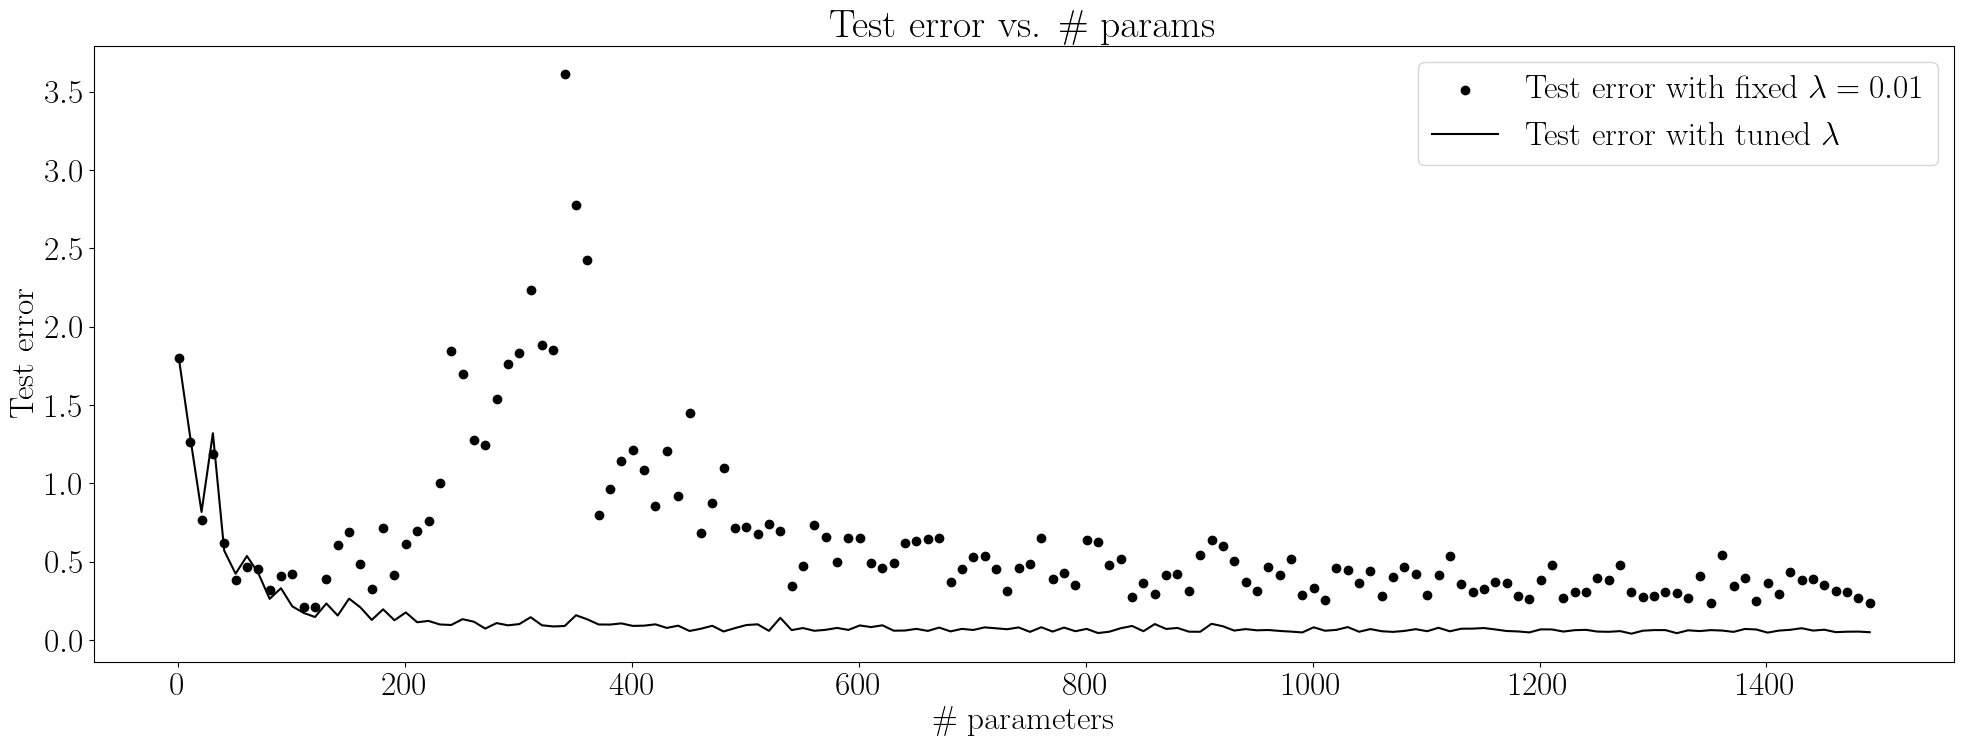

In [106]:
import matplotlib.pyplot as plt 
import numpy as np 


"""
Step 1 : Generate Toy data
"""

d = 35
n_train, n_val, n_test = 300, 60, 30
np.random.seed(0)
beta = np.random.randn(d)
beta_true = beta / np.linalg.norm(beta)
# Generate and fix training data
X_train = np.array([np.random.multivariate_normal(np.zeros(d), np.identity(d)) for _ in range(n_train)])
Y_train = X_train @ beta_true + np.random.normal(loc = 0.0, scale = 0.5, size = n_train)
# Generate and fix validation data (for tuning lambda). 
X_val = np.array([np.random.multivariate_normal(np.zeros(d), np.identity(d)) for _ in range(n_val)])
Y_val = X_val @ beta_true 
# Generate and fix test data
X_test = np.array([np.random.multivariate_normal(np.zeros(d), np.identity(d)) for _ in range(n_test)])
Y_test = X_test @ beta_true 


"""
Step 2 : Solve the problem
"""    

lambda_list = [2 ** i for i in range(-6, 6)]
num_params = np.arange(1,1501,10)

errors_opt_lambda = []
errors_fixed_lambda = []
for p in num_params : 
    W = np.random.randn(p, d) / np.sqrt(p)
    X_train_transformed = np.maximum(X_train @ W.T, 0)
    X_val_transformed = np.maximum(X_val @ W.T, 0)
    X_test_transformed = np.maximum(X_test @ W.T, 0)

    theta_fixed_lambda = np.linalg.solve(X_train_transformed.T @ X_train_transformed + 0.01 * np.eye(p), X_train_transformed.T @ Y_train)
    errors_fixed_lambda.append(np.mean((X_test_transformed @ theta_fixed_lambda - Y_test) ** 2))

    val_errors = []
    for lambda_ in lambda_list:
        theta_opt_lambda = np.linalg.solve(X_train_transformed.T @ X_train_transformed + lambda_ * np.eye(p), X_train_transformed.T @ Y_train)
        val_errors.append(np.mean((X_val_transformed @ theta_opt_lambda - Y_val) ** 2))
    optimal_lambda = lambda_list[np.argmin(val_errors)]
    theta_opt_lambda = np.linalg.solve(X_train_transformed.T @ X_train_transformed + optimal_lambda * np.eye(p), X_train_transformed.T @ Y_train)
    errors_opt_lambda.append(np.mean((X_test_transformed @ theta_opt_lambda - Y_test) ** 2))


"""
Step 3 : Plot the results
"""    

plt.figure(figsize = (24, 8))
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
plt.rc('font', size = 24)


plt.scatter(num_params, errors_fixed_lambda, color = 'black',
            label = r"Test error with fixed $\lambda = 0.01$",
            ) 
plt.legend()

plt.plot(num_params, errors_opt_lambda, 'k', label = r"Test error with tuned $\lambda$")
plt.legend()
plt.xlabel(r'$\#$ parameters')
plt.ylabel('Test error')
plt.title(r'Test error vs. $\#$ params')

plt.savefig('double_descent.png')
plt.show()